# Une courte introduction à Stan

https://mc-stan.org/

Stan est probablement le langage probabiliste le plus populaire, utilisé dans de nombreux domaines d'applications.

Pour ce TP, nous utiliserons 

- Jupyter (pour intéragir avec le notebook),
- L'interface Python [CmdStanPy](https://mc-stan.org/cmdstanpy/),
- Numpy (pour le calcul vectoriel),
- Pandas (pour manipuler les données et les resultats),
- Matplotlib et ipywidgets pour les visualisations.

In [2]:
from cmdstanpy import CmdStanModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/home/maxper/.pyenv/versions/3.12.0/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Un programme Stan contient plusieurs sections.
Les plus utilisées sont les suivantes

```stan
data {
  // input data
}
parameters {
  // latent random variables
}
model {
  // model definition
}
```

Il existe d'autres sections (`transformed data`, `transformed parameters`, `generated quantities`) qui permettent de faire du pre/post-traitement des données et des paramètres.

Par exemple, le programme suivant implémente le modèle classique qui infère le biais d'une pièce à partir d'observations statistiques.

In [2]:
coin_code = """
data {
  int N; // number of observations
  array[N] int<lower=0, upper=1> y; // array of observations
}
parameters {
  real<lower=0, upper=1> z; // coin bias
}
model {
  for (i in 1:N){
      y[i] ~ bernoulli(z);
  }
}
"""

# CmdStanPy can only read stan code from a file.
with open("./coin.stan", "w") as f:
    print(coin_code, file=f)

On peut ensuite instancier un modèle Stan à partir de ce code, puis lancer l'inférence sur des données concrètes.

In [3]:
# Dict fields must coincide with model's data.
data = {
    'N' : 10,
    'y' : [0, 1, 1, 0, 0, 0, 0, 0, 0, 0] 
}

stan_model = CmdStanModel(stan_file="coin.stan") # instantiate the model
stan_fit = stan_model.sample(data, chains=1) # run inference (1 chains to limit cpu)
stan_fit.summary() # Print result summary

12:34:33 - cmdstanpy - INFO - compiling stan file /home/maxper/probprog-23-24/td/td-stan/coin.stan to exe file /home/maxper/probprog-23-24/td/td-stan/coin
12:34:43 - cmdstanpy - INFO - compiled model executable: /home/maxper/probprog-23-24/td/td-stan/coin
12:34:43 - cmdstanpy - INFO - CmdStan start processing
chain 1 |█████████████████████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


12:34:43 - cmdstanpy - INFO - CmdStan done processing.


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-7.226610,0.030278,0.662608,-8.410100,-6.981940,-6.749910,478.926,95785.3,1.000630
z,0.244749,0.005303,0.113649,0.086147,0.229373,0.458648,459.360,91871.9,0.999691


Il est possible de récupérer les échantillons de la distribution a posteriori à l'aide de la méthode `stan_variable`.  
Par exemple `stan_fit.stan_variable("z")` renvoie un tableau numpy dont la première dimension correspond au nombre d'échantillons (par défaut 1000).
Les dimensions suivantes correspondent aux dimensions du paramètre demandé (ici un simple flottant).

On peut vérifier que la moyenne des échantillons (le long de la première dimension) est bien celle affichée par la méthode `summary`.

In [4]:
z_samples = stan_fit.stan_variable("z")
print(f"z samples shape: {z_samples.shape}")
print(f"z samples mean: {z_samples.mean(axis=0)}")

z samples shape: (1000,)
z samples mean: 0.24474917540000002


**Attention.**

- Les tableaux sont indicés à partir de 1 en Stan (mais 0 en Python)
- Tous les paramètres (variables déclarées dans `parameters`) doivent être continus.
- `~` ne peut être utilisé qu'avec des paramètres ou des données (variables aléatoires)
- Des variables intermédiaires peuvent être définis dans le modèle (e.g., `real foo; foo = 42;`) mais sans contrainte.

Le manuel Stan est disponible à l'adresse suivante : https://mc-stan.org/docs/2_28/stan-users-guide/index.html

## Exercice 1 : Baseball Hits 1970.

*Adapté du Tutorial ["Hierarchical Partial Pooling for Repeated Binary Trials"](https://mc-stan.org/users/documentation/case-studies/pool-binary-trials.html), B. Carpenter, 2016*

Dans cet exercice nous essayons de prevoir les performances des joueurs de baseball lors de la Major League Baseball season de 1970.  
Les données (Effron et Morris 1975) comprennent pour chaque batteur :
- Le nom, prénom, 
- Le nombre de succès après les 45 premiers essais,
- Le nombre d'essais restants jusqu'à la fin de la saison,
- Le nombre de succès restants jusqu'à la fin de la saison.

**Objectif.** Le but de ce problème est de prédire, pour chaque joueur, le nombre de succès restant à partir des resultats obtenus sur les 45 premiers essais.

In [5]:
df = pd.read_csv("EfronMorrisBB.txt", sep="\t")
df = df.rename(columns={"At-Bats": "Bats", "RemainingAt-Bats": "RemainingBats"})
df["RemainingHits"] = df["SeasonHits"] - df["Hits"]
df = df[["FirstName", "LastName", "Bats", "Hits", "RemainingBats","RemainingHits"]]

# Dictionnary contaning all the data.
data = {
    "N": df.shape[0],
    "K": df["Bats"].to_numpy(),
    "y": df["Hits"].to_numpy(),
}

df

,FirstName,LastName,Bats,Hits,RemainingBats,RemainingHits
0,Roberto,Clemente,45,18,367,127
1,Frank,Robinson,45,17,426,127
2,Frank,Howard,45,16,521,144
3,Jay,Johnstone,45,15,275,61
4,Ken,Berry,45,14,418,114
5,Jim,Spencer,45,14,466,126
6,Don,Kessinger,45,13,586,155
7,Luis,Alvarado,45,12,138,29
8,Ron,Santo,45,11,510,137
9,Ron,Swaboda,45,11,200,46


**Question 1.** On suppose dans un premier temps que tous les joueurs ont la même probabilité de réussite $\theta$ à chaque essai.  
Proposer un premier modèle qui permet d'inférer ce paramètre.

*Note.* voir loi binomiale.

In [6]:
baseball1_code="""
data {
    int N;
    array[N] int<lower=0> K;
    array[N] int<lower=0> y;
}
parameters {
    real<lower=0, upper=1> p;
}
model {
    for (i in 1:N){
      y[i] ~ binomial(45, p);
  }
}
"""

with open("./baseball1.stan", "w") as f:
    print(baseball1_code, file=f)

stan_model = CmdStanModel(stan_file="baseball1.stan")
stan_fit = stan_model.sample(data, chains=1)
stan_fit.summary()

12:41:47 - cmdstanpy - INFO - compiling stan file /home/maxper/probprog-23-24/td/td-stan/baseball1.stan to exe file /home/maxper/probprog-23-24/td/td-stan/baseball1
12:41:56 - cmdstanpy - INFO - compiled model executable: /home/maxper/probprog-23-24/td/td-stan/baseball1
12:41:56 - cmdstanpy - INFO - CmdStan start processing
chain 1 |█████████████████████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


12:41:56 - cmdstanpy - INFO - CmdStan done processing.


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-470.855000,0.030399,0.695866,-472.225000,-470.584000,-470.355000,523.996,87332.6,0.999058
p,0.265821,0.000782,0.015582,0.240212,0.265599,0.290415,397.495,66249.2,1.001940


**Question 2.** En déduire les predictions moyennes pour chacun des joueurs sachant le nombre d'essais restant jusqu'à la fin de la saison (colonne `df.RemainingBats`).

In [13]:
p = stan_fit.stan_variable("p").mean(axis=0)
df["Prediction1"] = df.RemainingBats * p
df

,FirstName,LastName,Bats,Hits,RemainingBats,RemainingHits,Prediction1
0,Roberto,Clemente,45,18,367,127,97.556426
1,Frank,Robinson,45,17,426,127,113.239884
2,Frank,Howard,45,16,521,144,138.492910
3,Jay,Johnstone,45,15,275,61,73.100864
4,Ken,Berry,45,14,418,114,111.113314
5,Jim,Spencer,45,14,466,126,123.872737
6,Don,Kessinger,45,13,586,155,155.771296
7,Luis,Alvarado,45,12,138,29,36.683343
8,Ron,Santo,45,11,510,137,135.568876
9,Ron,Swaboda,45,11,200,46,53.164265


Ce premier résultat est un bon début, mais il n'est pas très réaliste.
En pratique, les statistiques de certains batteurs sont [nettement supérieurs](https://www.baseball-reference.com/awards/hof_batting.shtml) à ceux des autres.

**Question 3.** Proposer un nouveau modèle, où les chances de succès de chaque joueur sont indépendantes des autres.

In [23]:
baseball2_code="""
data {
    int N;
    array[N] int<lower=0> K;
    array[N] int<lower=0> y;
}
parameters {
    array[N] real<lower=0, upper=1> p2;
}
model {
    for (i in 1:N){
      y[i] ~ binomial(45, p2[i]);
  }
}
"""

with open("./baseball2.stan", "w") as f:
    print(baseball2_code, file=f)

stan_model = CmdStanModel(stan_file="baseball2.stan")
stan_fit = stan_model.sample(data, chains=1)
stan_fit.summary()

12:52:28 - cmdstanpy - INFO - compiling stan file /home/maxper/probprog-23-24/td/td-stan/baseball2.stan to exe file /home/maxper/probprog-23-24/td/td-stan/baseball2
12:52:38 - cmdstanpy - INFO - compiled model executable: /home/maxper/probprog-23-24/td/td-stan/baseball2
12:52:38 - cmdstanpy - INFO - CmdStan start processing
chain 1 |█████████████████████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


12:52:38 - cmdstanpy - INFO - CmdStan done processing.


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-498.151000,0.147174,3.072670,-503.826000,-497.692000,-493.906000,435.885,22941.3,1.000000
p2[1],0.405990,0.001490,0.073204,0.288159,0.407096,0.528532,2412.760,126987.0,0.999312
p2[2],0.382779,0.001487,0.071368,0.266227,0.378818,0.509194,2304.600,121295.0,0.999106
p2[3],0.362677,0.001494,0.067868,0.247112,0.360295,0.476561,2062.850,108571.0,1.001620
p2[4],0.341329,0.001415,0.068730,0.231481,0.340090,0.453422,2360.900,124258.0,0.999262
p2[5],0.320096,0.001413,0.064670,0.217956,0.320138,0.427020,2094.890,110257.0,0.999199
p2[6],0.320037,0.001444,0.072241,0.206557,0.317785,0.440108,2503.570,131767.0,0.999496
p2[7],0.297984,0.001417,0.060659,0.200823,0.296414,0.402440,1832.220,96432.4,0.999001
p2[8],0.275022,0.001377,0.065850,0.171241,0.273393,0.388136,2286.930,120365.0,0.999004
p2[9],0.256085,0.001425,0.065455,0.157112,0.253807,0.370294,2109.130,111007.0,0.999002


**Question 4.** En déduire les nouvelles predictions pour chacun des joueurs sachant le nombre d'essais restant jusqu'à la fin de la saison.

*Note.* On pourra utiliser `stan_fit.stan_variable("theta")`.
Comme précédemment, on prendra pour chaque joueur la valeur moyenne de theta.

In [37]:
p2 = stan_fit.stan_variable("p2").mean(axis=0)
df["Prediction2"] = df.RemainingBats * p2
df

,FirstName,LastName,Bats,Hits,RemainingBats,RemainingHits,Prediction1,Prediction2
0,Roberto,Clemente,45,18,367,127,97.556426,148.998265
1,Frank,Robinson,45,17,426,127,113.239884,163.063798
2,Frank,Howard,45,16,521,144,138.492910,188.954770
3,Jay,Johnstone,45,15,275,61,73.100864,93.865519
4,Ken,Berry,45,14,418,114,111.113314,133.800311
5,Jim,Spencer,45,14,466,126,123.872737,149.137346
6,Don,Kessinger,45,13,586,155,155.771296,174.618498
7,Luis,Alvarado,45,12,138,29,36.683343,37.953046
8,Ron,Santo,45,11,510,137,135.568876,130.603235
9,Ron,Swaboda,45,11,200,46,53.164265,51.380776


Pour finir, on voudrait ajouter des effets de population globaux à tous les joueurs.
Par exemple, si tous les autres joueurs font une saison exceptionnelle, il est probable que Berry aura lui aussi de très bons résultats.

On suppose maintenant que pour chaque joueur le paramètre $\theta$ suit une loi $\rm{Beta}(\alpha, \beta)$ (comme pour la pièce biaisée), où les paramètres $\alpha$, et $\beta$ sont communs à tous les joueurs.
On a maintenant un modèle hierarchique (le paramètre $\theta$ dépend lui même de 2 autres paramètres).

Il peut être difficile de trouver une bonne distribution a priori pour ces "hyperparamètres" $\alpha$, et $\beta$.
Pour contourner ce problème, on peut "reparamétriser" le modèle en introduisant les paramètres $\phi \in [0, 1]$ et $\kappa \in [1, \infty)$ tels que : 

$$
\alpha = \kappa * \phi
\quad
\beta = \kappa * (1 - \phi)
$$

La litérature propose alors les distributions a priori suivantes pour $\kappa$ et $\phi$ :
$$
\phi \sim \rm{Uniform}(0, 1)
\quad
\kappa \sim \rm{Pareto}(1, 1.5)
$$


**Question 5.** Implémenter ce dernier modèle en Stan.

In [41]:
baseball3_code = """
data {
    int N;
    array[N] int<lower=0> K;
    array[N] int<lower=0> y;
}
parameters {
    real<lower=0, upper=1> phi;
    real<lower=1> kappa;
    array[N] real<lower=0, upper=1> p3;
}
model {
    phi ~ uniform(0,1);
    kappa ~ pareto(1, 1.5);
    
    for (i in 1:N){
      p3[i] ~ beta(kappa * phi, kappa * (1-phi));
      y[i] ~ binomial(45, p3[i]);
  }
}
"""

with open("./baseball3.stan", "w") as f:
    print(baseball3_code, file=f)

stan_model = CmdStanModel(stan_file="baseball3.stan")
stan_fit = stan_model.sample(data, chains=1)
stan_fit.summary()

13:17:50 - cmdstanpy - INFO - compiling stan file /home/maxper/probprog-23-24/td/td-stan/baseball3.stan to exe file /home/maxper/probprog-23-24/td/td-stan/baseball3
13:18:00 - cmdstanpy - INFO - compiled model executable: /home/maxper/probprog-23-24/td/td-stan/baseball3
13:18:00 - cmdstanpy - INFO - CmdStan start processing
chain 1 |█████████████████████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


13:18:00 - cmdstanpy - INFO - CmdStan done processing.
13:18:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'baseball3.stan', line 17, column 6 to column 49)
Consider re-running with show_console=True if the above output is unclear!
13:18:00 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-476.241000,0.530260,5.591620,-484.775000,-476.391000,-465.926000,111.198,2223.97,1.005490
phi,0.268218,0.000726,0.020434,0.236722,0.267756,0.302903,791.515,15830.30,1.001070
kappa,92.061200,10.268100,106.986000,19.977000,59.810000,287.817000,108.561,2171.21,1.017120
p3[1],0.324598,0.002093,0.052303,0.252078,0.316995,0.416155,624.447,12488.90,1.000010
p3[2],0.315722,0.001780,0.051652,0.237756,0.311535,0.412917,842.298,16846.00,0.999662
p3[3],0.304912,0.001684,0.050005,0.230541,0.299301,0.394891,882.224,17644.50,0.999357
p3[4],0.296546,0.001581,0.047269,0.225914,0.294471,0.378899,894.240,17884.80,1.000150
p3[5],0.283792,0.001300,0.044830,0.213224,0.282080,0.358339,1189.850,23797.00,0.999644
p3[6],0.285143,0.001291,0.046940,0.212423,0.282803,0.367436,1321.720,26434.40,1.001150
p3[7],0.278272,0.001229,0.046051,0.205227,0.274805,0.358207,1403.280,28065.60,0.999625


**Question 6.** En déduire les nouvelles prédictions pour chaque joueur.

In [42]:
p3 = stan_fit.stan_variable("p3").mean(axis=0)
df["Prediction3"] = df.RemainingBats * p3
df

,FirstName,LastName,Bats,Hits,RemainingBats,RemainingHits,Prediction1,Prediction2,Prediction3
0,Roberto,Clemente,45,18,367,127,97.556426,148.998265,119.127328
1,Frank,Robinson,45,17,426,127,113.239884,163.063798,134.497759
2,Frank,Howard,45,16,521,144,138.492910,188.954770,158.859290
3,Jay,Johnstone,45,15,275,61,73.100864,93.865519,81.550127
4,Ken,Berry,45,14,418,114,111.113314,133.800311,118.625180
5,Jim,Spencer,45,14,466,126,123.872737,149.137346,132.876451
6,Don,Kessinger,45,13,586,155,155.771296,174.618498,163.067496
7,Luis,Alvarado,45,12,138,29,36.683343,37.953046,36.653310
8,Ron,Santo,45,11,510,137,135.568876,130.603235,131.482610
9,Ron,Swaboda,45,11,200,46,53.164265,51.380776,51.575477


## Exercice 2 : Variations sur une régression linéaire.

**Objectif.** Le but de cet exercice est d'utiliser Stan pour trouver une regression linéaire.  
Plutôt que de trouver la meilleure solution, on cherche ici une distribution de regressions possibles.

On considère les données bruitées suivantes.

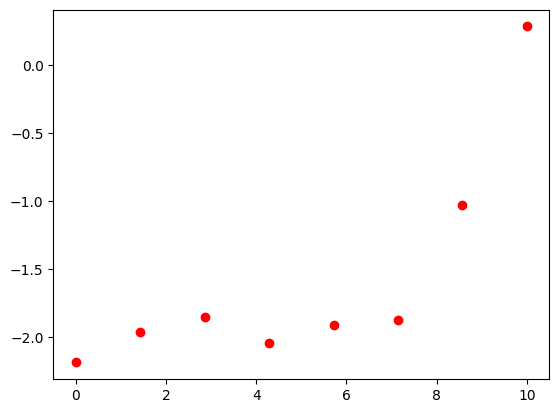

In [3]:
N = 8
noise = 0.25
lower = 0
upper = 10

x_obs = np.linspace(lower, upper, N)
y_obs = 2 * np.tanh(4 * (x_obs - upper) / upper) + noise * np.random.randn(N)

data = {
    'N': N,
    'low': lower,
    'up': upper,
    'x': x_obs,
    'y': y_obs
}

plt.scatter(x_obs, y_obs, color='red')

**Question 1.** Proposer un premier modèle de regression linéaire $y \sim \mathcal{N}(ax + b, \sigma)$.  
On cherche à estimer les paramètres $a$, $b$, et $\sigma$ (bruit).

In [4]:
regression1_code = """
data {
    int N;
    array[N] real x;
    array[N] real y;
}
parameters {
    real a;
    real b;
    real<lower=0> sigma;
}
model {
    for (i in 1:N){
      y[i] ~ normal(a * x[i] + b, sigma);
  }
}
"""

with open("./regression1.stan", "w") as f:
    print(regression1_code, file=f)

stan_model = CmdStanModel(stan_file="regression1.stan")
stan_fit = stan_model.sample(data, chains=1)
stan_fit.summary()

09:50:15 - cmdstanpy - INFO - compiling stan file /home/maxper/probprog-23-24/td/td-stan/regression1.stan to exe file /home/maxper/probprog-23-24/td/td-stan/regression1
09:50:27 - cmdstanpy - INFO - compiled model executable: /home/maxper/probprog-23-24/td/td-stan/regression1
09:50:27 - cmdstanpy - INFO - CmdStan start processing
chain 1 |█████████████████████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


09:50:27 - cmdstanpy - INFO - CmdStan done processing.


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-0.754232,0.127940,1.626930,-3.986090,-0.230148,0.874002,161.706,14700.5,1.01352
a,0.180875,0.004219,0.079626,0.055674,0.180247,0.307077,356.174,32379.5,1.00050
b,-2.468680,0.026977,0.478835,-3.198090,-2.463370,-1.718150,315.048,28640.7,1.00025
sigma,0.730220,0.020641,0.353579,0.407440,0.638989,1.389400,293.431,26675.5,1.00174


On peut maintenant afficher quelque échantillons pour observer la distribution obtenue.

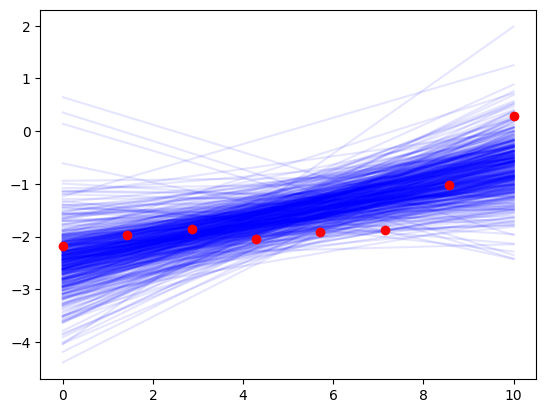

In [5]:
for i in range(500):
    x = np.linspace(lower, upper, 2)
    a = stan_fit.stan_variable("a")[i]
    b = stan_fit.stan_variable("b")[i]
    plt.plot(x, a * x + b, color='blue', alpha=0.1, zorder=0)
    
plt.scatter(x_obs, y_obs, color='red', zorder=1)

Le résultat correspond à nos attente, mais n'est pas formidable pour notre jeux de données où on observe une rupture de pente.

**Question 2.** Proposer un nouveau modèle avec un paramètre supplémentaire `cut` pour ce point de rupture et deux regressions : avant et après ce point.
On pourra representer les paramètres `a` et `b` par des vecteurs à 2 dimensions.

In [6]:
regression2_code = """
data {
    int N;
    array[N] real x;
    array[N] real y;
    real low;
    real up;
}
parameters {
    array[2] real a;
    array[2] real b;
    real<lower=low,upper=up> cut;
    real<lower=0> sigma;
}
model {
    cut ~ uniform(low, up);
    sigma ~ exponential(1);
    a ~ normal(0, 10);
    b ~ normal(0, 10);
    
    for (i in 1:N){
        if(x[i] < cut){
          y[i] ~ normal(a[1] * x[i] + b[1], sigma);
        }
        else{
          y[i] ~ normal(a[2] * x[i] + b[2], sigma);
        }
  }
}
"""

with open("./regression2.stan", "w") as f:
    print(regression2_code, file=f)

stan_model = CmdStanModel(stan_file="regression2.stan")
stan_fit = stan_model.sample(data, chains=1)
stan_fit.summary()

09:50:38 - cmdstanpy - INFO - compiling stan file /home/maxper/probprog-23-24/td/td-stan/regression2.stan to exe file /home/maxper/probprog-23-24/td/td-stan/regression2
09:50:49 - cmdstanpy - INFO - compiled model executable: /home/maxper/probprog-23-24/td/td-stan/regression2
09:50:49 - cmdstanpy - INFO - CmdStan start processing
chain 1 |█████████████████████████████████████████████████████████████████████████████████████| 00:01 Sampling completed


09:50:50 - cmdstanpy - INFO - CmdStan done processing.
09:50:50 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 703 iterations at max treedepth (70.3%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,6.655780,1.784060,4.219210,0.159131,6.196710,12.798100,5.59301,6.05304,1.67206
a[1],0.056993,0.010401,0.050769,-0.013703,0.048741,0.144756,23.82820,25.78810,1.14820
a[2],0.262941,0.353778,0.752339,-1.236990,0.617766,1.012870,4.52237,4.89434,1.83145
b[1],-2.142230,0.021225,0.203245,-2.476830,-2.129210,-1.822350,91.69360,99.23550,1.01235
b[2],-2.422650,3.548100,7.524750,-9.775810,-6.151490,12.047200,4.49771,4.86765,1.83233
cut,7.930360,0.459450,1.487380,5.750410,8.137760,9.616060,10.48017,11.34218,1.14549
sigma,0.261230,0.044340,0.161980,0.085120,0.225450,0.583150,13.34656,14.44433,1.30207


On peut à nouveau visualiser la distribution obtenue.

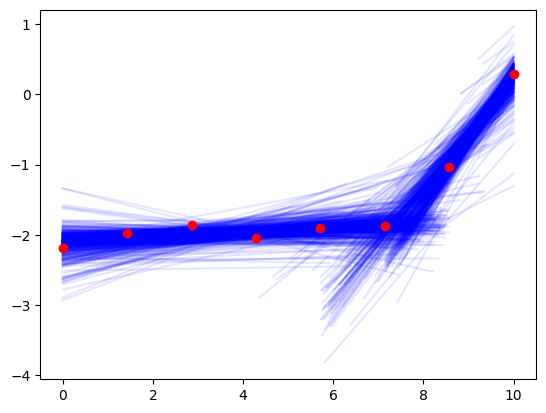

In [7]:
for i in range(500):
    a = stan_fit.stan_variable("a")[i]
    b = stan_fit.stan_variable("b")[i]
    cut = stan_fit.stan_variable("cut")[i]
    x = np.linspace(lower, cut, 2)
    plt.plot(x, a[0] * x + b[0], color='blue', alpha=0.1, zorder=0)
    x = np.linspace(cut, upper, 2)
    plt.plot(x, a[1] * x + b[1], color='blue', alpha=0.1, zorder=0)
    
plt.scatter(x_obs, y_obs, color='red', zorder=1)

**Question 3.** Proposer maintenant un modèle ou le nombre (maximal) de changement de pente $C$ est donné.  
(Pour simplifier on pourra fixer la valeur du bruit $\sigma$ dans ce modèle à une valeur raisonnable).
Les points de rupture `cuts` pourront être stockés dans un vecteur trié de dimension $C$ (cf. fonction `sort_asc`).

In [47]:
regression3_code = """
data {
    int N;
    array[N] real x;
    array[N] real y;
    real low;
    real up;
    int C;
}
parameters {
    array[C+1] real a;
    array[C+1] real b;
    vector<lower=low,upper=up>[C] unsortedcuts;
    real<lower=0> sigma;
}
transformed parameters {
    vector<lower=low,upper=up>[C] cuts;
    cuts = sort_asc(unsortedcuts);
}
model {
    cuts ~ uniform(low, up);
    sigma ~ exponential(1);
    a ~ normal(0, 10);
    b ~ normal(0, 10);
    
    for (i in 1:N){
       for(c in 1:C) {
        if((c == C || x[i] <= cuts[c+1]) && (C == 1 || x[i] > cuts[c])){
          y[i] ~ normal(a[c] * x[i] + b[c], sigma);
        }
    }
  }
}
"""

with open("./regression3.stan", "w") as f:
    print(regression3_code, file=f)

On peut maintenant essayer le même jeu de données avec plus de rupture de pente.

In [48]:
C = 4

stan_model = CmdStanModel(stan_file="regression3.stan")
stan_fit = stan_model.sample(data = {**data, 'C':C}, chains=1)
stan_fit.summary()

10:26:57 - cmdstanpy - INFO - compiling stan file /home/maxper/probprog-23-24/td/td-stan/regression3.stan to exe file /home/maxper/probprog-23-24/td/td-stan/regression3
10:27:11 - cmdstanpy - INFO - compiled model executable: /home/maxper/probprog-23-24/td/td-stan/regression3
10:27:11 - cmdstanpy - INFO - CmdStan start processing
chain 1 |█████████████████████████████████████████████████████████████████████████████████████| 00:02 Sampling completed


10:27:14 - cmdstanpy - INFO - CmdStan done processing.
10:27:14 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1000 iterations at max treedepth (100.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-4.115750,0.797823,2.358580,-8.920240,-3.685580,-0.915373,8.73952,6.11155,0.99924
a[1],-4.071340,0.173429,0.300259,-4.573790,-4.126000,-3.646400,2.99744,2.09611,2.44209
a[2],9.273490,1.629710,3.495950,3.891610,9.022930,15.076100,4.60160,3.21790,1.52416
a[3],0.005734,0.068182,0.211611,-0.391392,0.046048,0.279181,9.63245,6.73598,1.02792
a[4],0.161453,0.014014,0.053531,0.043585,0.166312,0.235977,14.59080,10.20340,1.06857
a[5],3.359830,0.285246,0.792097,1.974510,3.388270,4.635970,7.71112,5.39239,1.21502
b[1],-2.983960,0.733276,1.431600,-5.821320,-3.097510,-0.962864,3.81162,2.66547,1.90854
b[2],3.709500,1.251500,3.174350,-1.948100,4.066050,8.379160,6.43345,4.49892,1.08448
b[3],-1.554070,0.274206,0.816118,-2.790700,-1.622290,-0.050668,8.85835,6.19465,1.00335
b[4],-1.395000,0.425219,0.974660,-2.700950,-1.568540,0.393611,5.25389,3.67405,1.33685


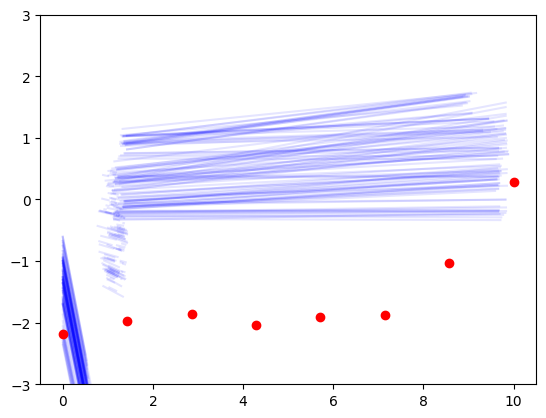

In [49]:
ax = plt.gca()
ax.set_ylim(-3, 3)
for i in range(100):
    cuts = np.append(stan_fit.stan_variable("cuts")[i], upper)
    a = stan_fit.stan_variable("a")[i]
    b = stan_fit.stan_variable("b")[i]
    low = lower
    for j in range(0,C+1):
        up = cuts[j]
        x = np.linspace(low, up, 2)
        plt.plot(x, a[j] * x + b[j], color='blue', alpha=0.1, zorder=0)
        low = up
    
plt.scatter(x_obs, y_obs, color='red', zorder=1)

Et maintenant sur un jeu de données plus compliqué.

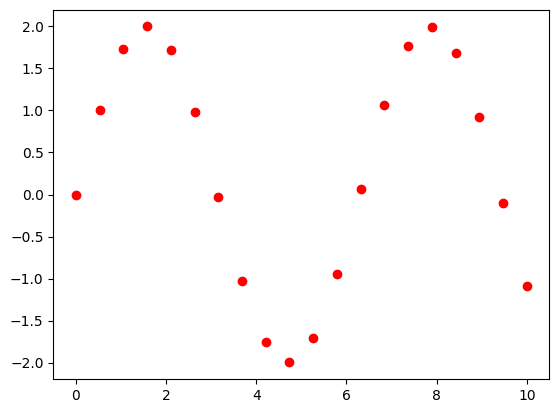

In [79]:
N = 20
x_obs = np.linspace(lower, upper, N)
y_obs = 2 * np.sin(x_obs)

data = {
    **data,
    'N': N, 
    'C': C,
    'x': x_obs,
    'y': y_obs
}

plt.scatter(x_obs, y_obs, color='red', zorder=1)

In [80]:
stan_model = CmdStanModel(stan_file="regression3.stan")
stan_fit = stan_model.sample(data, chains=1)

14:25:37 - cmdstanpy - INFO - CmdStan start processing
chain 1 |█████████████████████████████████████████████████████████████████████████████████████| 00:05 Sampling completed


14:25:42 - cmdstanpy - INFO - CmdStan done processing.
14:25:42 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1000 iterations at max treedepth (100.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


IndexError: index 4 is out of bounds for axis 0 with size 4

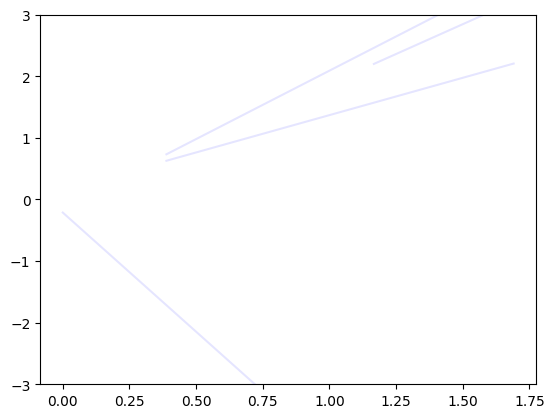

In [81]:
ax = plt.gca()
ax.set_ylim(-3, 3)
for i in range(100):
    cuts = np.append(stan_fit.stan_variable("cuts")[i], upper)
    a = stan_fit.stan_variable("a")[i]
    b = stan_fit.stan_variable("b")[i]
    low = lower
    for j in range(0,C+1):
        up = cuts[j]
        x = np.linspace(low, up, 2)
        plt.plot(x, a[j] * x + b[j], color='blue', alpha=0.1, zorder=0)
        low = up
    
plt.scatter(x_obs, y_obs, color='red', zorder=1)